# Kickstarter Projects

## 目的
**プロジェクトのカテゴリや最終的に集めたい金額などからクラウドファンディングが成功するかどうかを予測する**

## Kaggle
https://www.kaggle.com/kemical/kickstarter-projects

# データセットの確認

## データの読み込み

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import datetime

In [2]:
# 分析用データとして ks-projects-201801.csv のみを用いる
data = pd.read_csv('./ks-projects-201801.csv' )

data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## 各列の説明

参考) : <br>
https://kickstarternavi.jp/tips/196/<br>

https://help.kickstarter.com/hc/ja/articles/115005028514-Kickstarter-%E3%81%AE%E5%9F%BA%E6%9C%AC%E3%81%A8%E3%81%AF%E3%81%AA%E3%82%93%E3%81%A7%E3%81%99%E3%81%8B-

| 列名 | 説明 |
|:-|:-|
|　ID　|　識別番号　|
| name | クラウドファンディングのプロジェクト名 |
| category | カテゴリー |
| main_category | おおまかなカテゴリー |
| currency | 支援に必要な通貨 |
| deadline | クラウドファンディングの締め切り日 |
| goal | 集めたい金額 |
| launched | クラウドファンディングの開始日時 |
| pledged | 最終的に集まった支援金額 |
| state | 成功したかどうか　(今回の目的変数) |
| backers | 支援者の人数 |
| country | 募集側の国名 |
| usd pledged | 最終的に集まった支援金額(USドル, Kickstarterが掲載している金額) |
| usd_pledged_real | 最終的に集まった支援金額(USドル, Fixer.io APIによって計算した金額) |
| usd_goal_real | 集めたい金額(USドル) |

今回は成功するかどうかを予測するモデルを作りたいので，目的変数は **state** である．<br>
また予測はクラウドファンディングの募集開始前に行うので，
- pledged
- backers
- usd pledged
- usd_pledged_real

は説明変数として用いないものとする．

さらに
- IDはただの識別番号であり，予測に使用できるものではない点
- nameにも多くの情報は含まれているが，一つ一つが異なり扱いが非常に難しい点

からID, nameについても説明変数としては用いないものとする．

In [3]:
# dataから説明変数として用いない変数を消去
data.drop(['ID', 'name', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'], axis=1, inplace=True)

data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00


## 各列の代表値と欠損値

In [4]:
# 量的変数の代表値を表示
data.describe()

,goal,usd_goal_real
count,3.786610e+05,3.786610e+05
mean,4.908079e+04,4.545440e+04
std,1.183391e+06,1.152950e+06
min,1.000000e-02,1.000000e-02
25%,2.000000e+03,2.000000e+03
50%,5.200000e+03,5.500000e+03
75%,1.600000e+04,1.550000e+04
max,1.000000e+08,1.663614e+08


In [5]:
# データ数の確認
data.shape

(378661, 9)

goalとusd_goal_realの最小値が1ドルを切っている． $\rightarrow$ 異常値の可能性があるので要確認<br>
goalの平均額が第三四分位数よりも大きくなっている． $\rightarrow$ goalの分布は高額なものがかなり少ないと予想

In [6]:
# dataの欠損値確認
data.isnull().sum()

category         0
main_category    0
currency         0
deadline         0
goal             0
launched         0
state            0
country          0
usd_goal_real    0
dtype: int64

上記から今回用いるデータには欠損値がないことがわかるので，欠損値の補完は行わない．

# 変数の分布の可視化

## 目的変数の分布の可視化

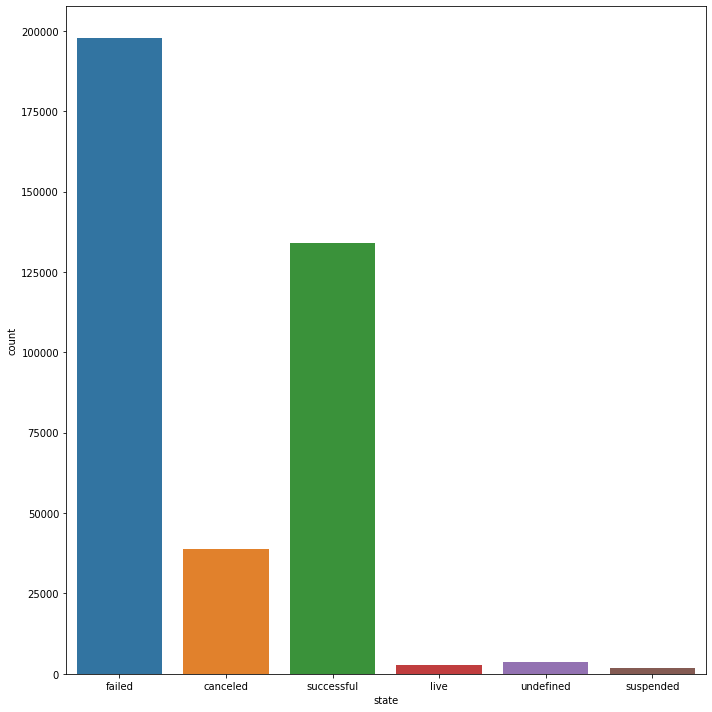

In [7]:
plt.figure(figsize=(10, 10))
sns.countplot(x='state', data=data)
plt.tight_layout()

In [8]:
data['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [9]:
data_successful = data['state']=='successful'
print(f'クラウドファンディングの成功率 : {data_successful.sum() / data.shape[0]}')

クラウドファンディングの成功率 : 0.3537623362321443


In [10]:
data_live = data['state']=='live'
print(f'liveの割合 : {data_live.sum() / data.shape[0]}')
print(f'liveのデータ数 : {data_live.sum()}')

liveの割合 : 0.0073918359693763026
liveのデータ数 : 2799


In [11]:
data_failed = data['state']=='failed'
print(f'successful + failed : {(data_successful.sum() + data_failed.sum()) / data.shape[0]}')

successful + failed : 0.8759153966212523


クラウドファンディングの成功率は35.38%と，半分以上は成功していないことがわかる．<br>
successfulとfailedが全体の87.59%を占めていることがわかる．<br>
また，全体の0.74%を占めるliveはまだクラウドファンディングを行っているデータであることもわかる．<br>
今回はクラウドファンディングが成功するかどうかを予測したいので，liveは分析のデータから除外し，successful以外の4つのカテゴリについてはfailedとしてまとめて分析を行うものとする．

In [12]:
# 最後にliveの予測を行うため，stateがliveのデータをdata_live_onlyとして保持
data_live_only = data[data['state']=='live']
# live以外のデータ
data = data[data['state']!='live']
data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,canceled,US,19500.00


In [13]:
# dataのsuccessful以外のカテゴリをfailedに変更
data = data.replace({'canceled' : 'failed', 'undefined' : 'failed', 'suspended' : 'failed'})
data['state'].unique()

array(['failed', 'successful'], dtype=object)

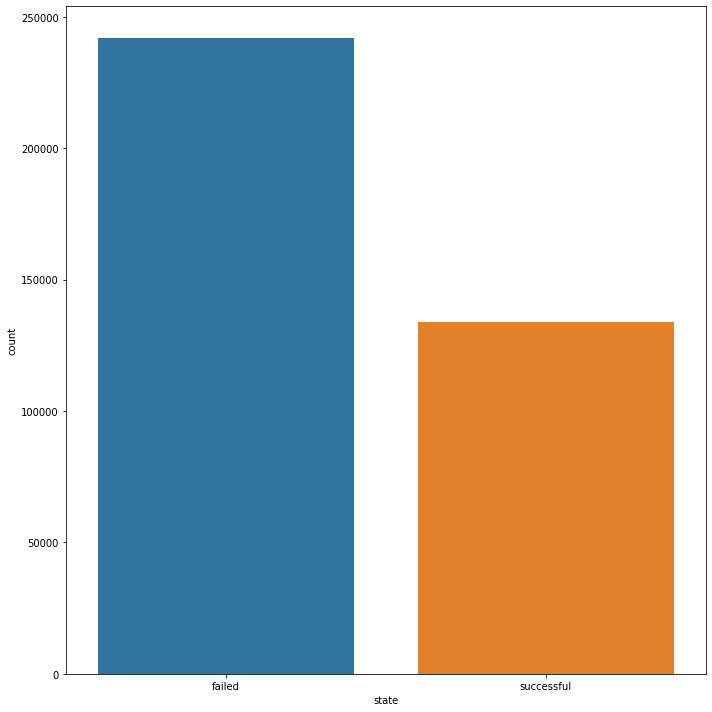

In [54]:
plt.figure(figsize=(10, 10))
sns.countplot(x='state', data=data)
plt.tight_layout()

## 説明変数の分布の可視化

### category

In [14]:
data['category'].value_counts()

Product Design     22077
Documentary        16082
Music              15647
Tabletop Games     14072
Shorts             12311
                   ...  
Residencies           69
Letterpress           48
Chiptune              35
Literary Spaces       23
Taxidermy             13
Name: category, Length: 159, dtype: int64

In [15]:
print(set(data['category']))

{'Fashion', 'Periodicals', 'Ceramics', 'Mobile Games', 'Camera Equipment', '3D Printing', 'Knitting', 'Performances', 'Classical Music', 'Technology', 'Indie Rock', 'Community Gardens', 'Journalism', 'Software', 'Wearables', 'Printing', 'Nature', 'Pet Fashion', 'Performance Art', 'Animation', 'Fantasy', 'Apps', 'Illustration', 'Vegan', 'Young Adult', 'Fabrication Tools', 'Puzzles', 'Rock', 'Academic', 'Conceptual Art', 'Ready-to-wear', 'Digital Art', 'Design', 'Art Books', 'Comic Books', 'Experimental', 'Music', 'Crafts', 'Candles', 'Dance', "Children's Books", 'Poetry', 'Product Design', 'Thrillers', 'Plays', 'Textiles', 'Calendars', 'Accessories', 'Pottery', 'Food Trucks', 'Public Art', 'Couture', 'Movie Theaters', 'Chiptune', 'Cookbooks', 'Weaving', 'Architecture', 'Faith', 'Punk', 'Interactive Design', 'Family', 'Documentary', 'Translations', 'Theater', 'Robots', 'Places', 'Sound', 'Web', 'Publishing', 'Hip-Hop', 'Art', 'Literary Journals', 'Woodworking', 'Photobooks', 'Events', "F

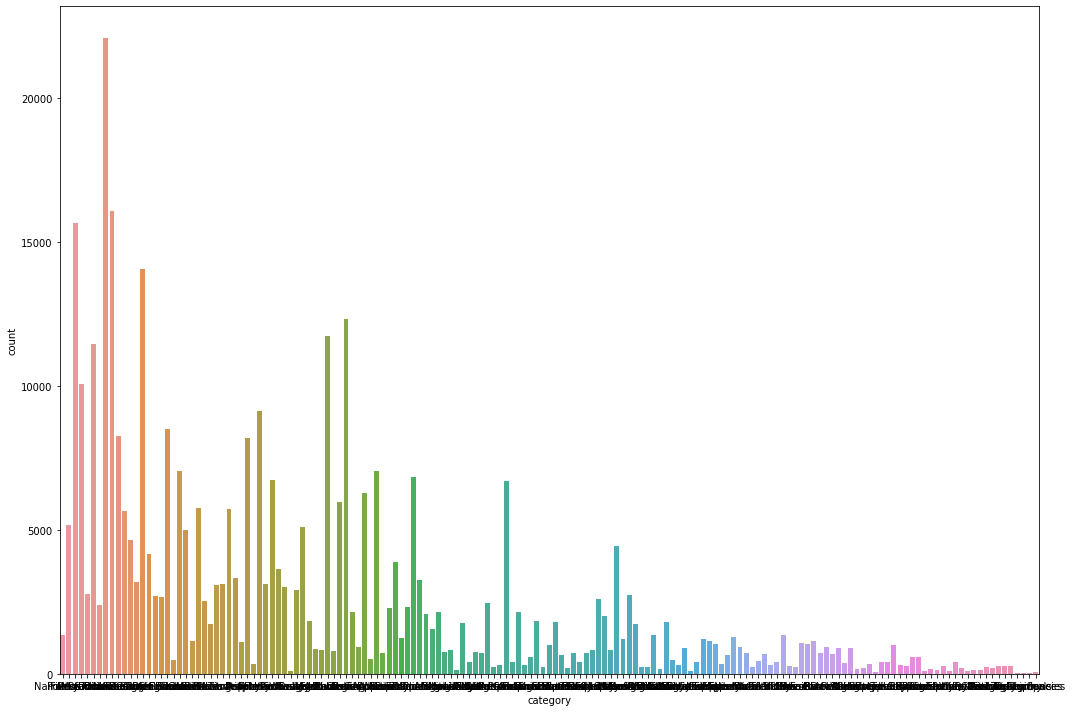

In [16]:
plt.figure(figsize=(15,10))
sns.countplot(x='category', data=data)
plt.tight_layout()

In [17]:
data_category = data['category'].value_counts()
data_category = pd.DataFrame(data_category)

print('categoryの出現回数が3000回以上のカテゴリ数')
print(sum(data_category['category'] >= 3000))
print('categoryの出現回数が3000回以上のデータ数')
print(data_category[data_category['category'] >= 3000].sum()[0] / data.shape[0])

categoryの出現回数が3000回以上のカテゴリ数
37
categoryの出現回数が3000回以上のデータ数
0.7168109572130197


categoryはmian_categoryをより詳しく分類したもので，159種類ある．<br>
このまま用いるとカテゴリ数が多く，各カテゴリの出現回数にはばらつきがあるため，出現頻度の少ないカテゴリをまとめてしまいたい．<br>
そこで出現回数が3000回以上のカテゴリはそのまま用いて，3000回以下のカテゴリをまとめることを考える．<br>
この場合全体の28.32%がその他に分類されることになり，カテゴリ数を1/4程度に減らすことができる．

### main_category

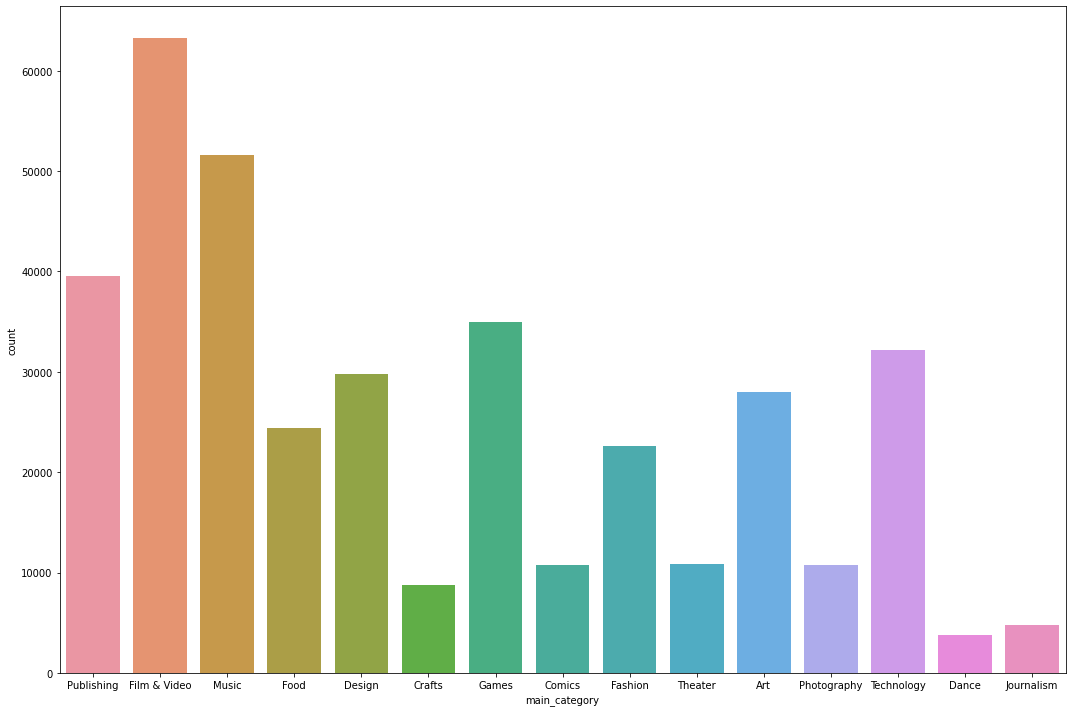

In [18]:
plt.figure(figsize=(15,10))
sns.countplot(x='main_category', data=data)
plt.tight_layout()

In [19]:
data['main_category'].value_counts()

Film & Video    63253
Music           51637
Publishing      39575
Games           34944
Technology      32192
Design          29765
Art             27959
Food            24418
Fashion         22566
Theater         10872
Comics          10743
Photography     10731
Crafts           8733
Journalism       4724
Dance            3750
Name: main_category, dtype: int64

main_categoryは15種類存在する．<br>
カテゴリごとの数にばらつきはあるが，どのカテゴリも一定程度のデータ数を有しているのでmain_category変数はこのまま使用する．

### currency

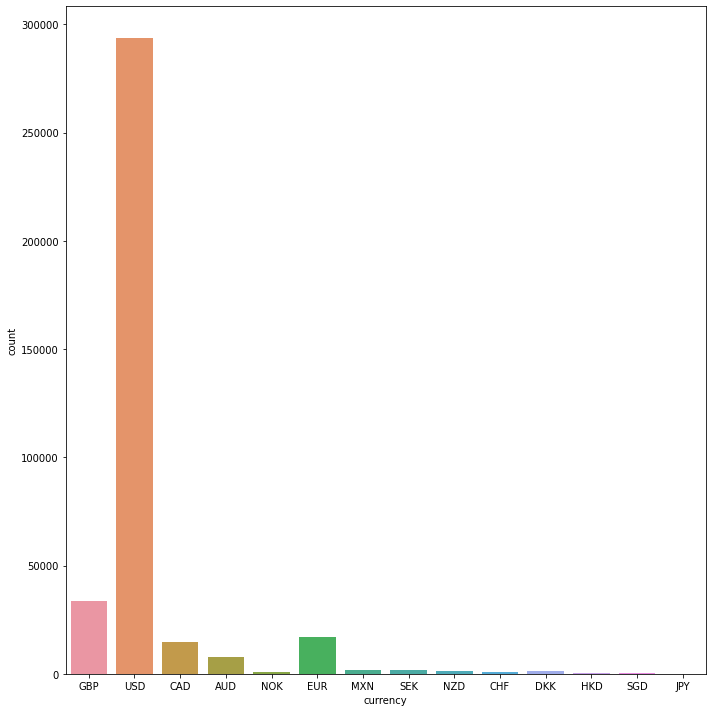

In [20]:
plt.figure(figsize=(10, 10))
sns.countplot(x='currency', data=data)
plt.tight_layout()

In [21]:
data['currency'].value_counts()

USD    293624
GBP     33853
EUR     17076
CAD     14830
AUD      7880
SEK      1768
MXN      1645
NZD      1464
DKK      1113
CHF       754
NOK       714
HKD       583
SGD       527
JPY        31
Name: currency, dtype: int64

In [22]:
data_USD = data['currency']=='USD'
print(f'USDの割合 : {data_USD.sum() / data.shape[0]}')

USDの割合 : 0.7812016112296535


In [23]:
data_GBP = data['currency']=='GBP'
data_EUR = data['currency']=='EUR'
data_CAD = data['currency']=='CAD'
data_AUD = data['currency']=='AUD'
print(f'USD, GBP, EUR, CAD, AUDが占める割合 : {(data_USD.sum() + data_GBP.sum() + data_EUR.sum() + data_CAD.sum() + data_AUD.sum()) / data.shape[0]}')

USD, GBP, EUR, CAD, AUDが占める割合 : 0.9771219224076921


currencyの分布からクラウドファンディングで使用される通貨の78%はUSDであることがわかる．<br>
またUSD, GBP, EUR, CAD, AUDで全体の97.71%を占めている為，その他の通貨に関してはtheotherでまとめて扱うものとする．

In [81]:
# USD, GBP, EUR, CAD, AUD以外をcur_otherに書き換える
data = data.replace({'NOK' : 'cur_other', 'MXN' : 'cur_other', 'SEK' : 'cur_other', 'NZD' : 'cur_other', 'CHF' : 'cur_other', 'DKK' : 'cur_other', 'HKD' : 'cur_other', 'SGD' : 'cur_other', 'JPY' : 'cur_other'})
data['currency'].unique()

array(['GBP', 'USD', 'CAD', 'AUD', 'cur_other', 'EUR'], dtype=object)

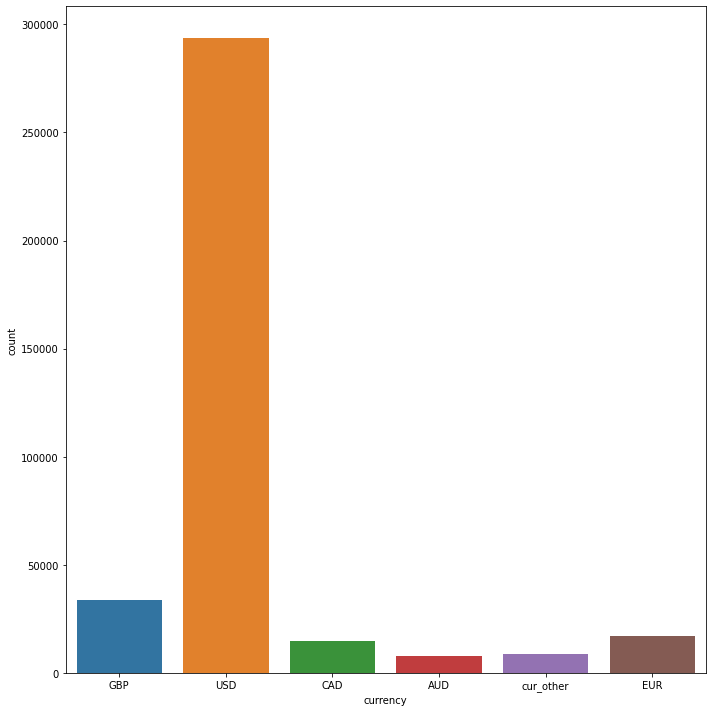

In [82]:
plt.figure(figsize=(10, 10))
sns.countplot(x='currency', data=data)
plt.tight_layout()

### country

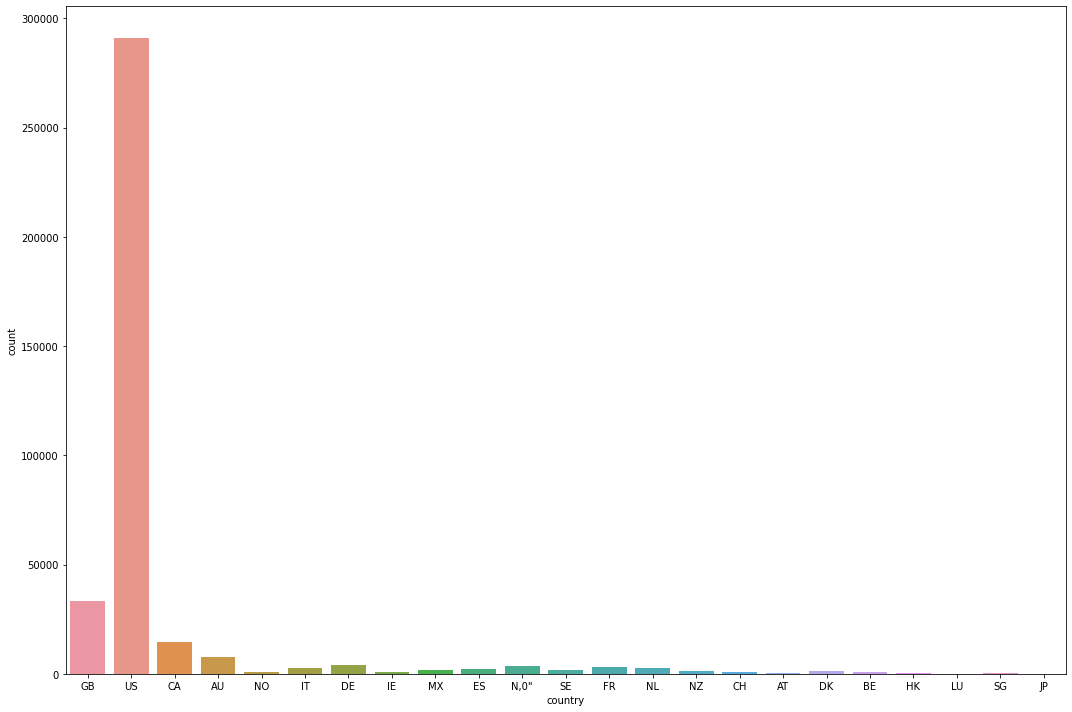

In [24]:
plt.figure(figsize=(15, 10))
sns.countplot(x='country', data=data)
plt.tight_layout()

In [25]:
data['country'].value_counts()

US      290887
GB       33393
CA       14624
AU        7769
DE        4096
N,0"      3796
FR        2887
NL        2833
IT        2802
ES        2224
SE        1737
MX        1645
NZ        1436
DK        1097
IE         800
CH         747
NO         700
BE         605
HK         583
AT         582
SG         527
LU          61
JP          31
Name: country, dtype: int64

In [26]:
data_US = data['country']=='US'
print(f'USの割合 : {data_US.sum() / data.shape[0]}')

USの割合 : 0.7739196832880153


In [27]:
data_GB = data['country']=='GB'
data_CA = data['country']=='CA'
data_AU = data['country']=='AU'
print(f'US + GB + CA + AUの割合 : {(data_US.sum() + data_GB.sum() + data_CA.sum() + data_AU.sum()) / data.shape[0]}')

US + GB + CA + AUの割合 : 0.9223411784112254


USでの募集が全体の77.39%を占めている．<br>
この変数はcurrencyと同様に，US，GB，CA，AUで全体の92.23%を占めているので，その他の国についてはtheotherでまとめて扱うものとする．

In [83]:
# US, GB, CA, AU以外をcou_otherに書き換える
data = data.replace({'NO' : 'cou_other', 'IT' : 'cou_other', 'DE' : 'cou_other', 'IE' : 'cou_other', 'MX' : 'cou_other', 'ES' : 'cou_other', 'N,0"' : 'cou_other', 'SE' : 'cou_other', 'FR' : 'cou_other', 'NL' : 'cou_other', 'NZ' : 'cou_other', 'CH' : 'cou_other', 'AT' : 'cou_other', 'DK' : 'cou_other', 'BE' : 'cou_other', 'HK' : 'cou_other', 'LU' : 'cou_other', 'SG' : 'cou_other', 'JP' : 'cou_other'})
data['country'].unique()

array(['GB', 'US', 'CA', 'AU', 'cou_other'], dtype=object)

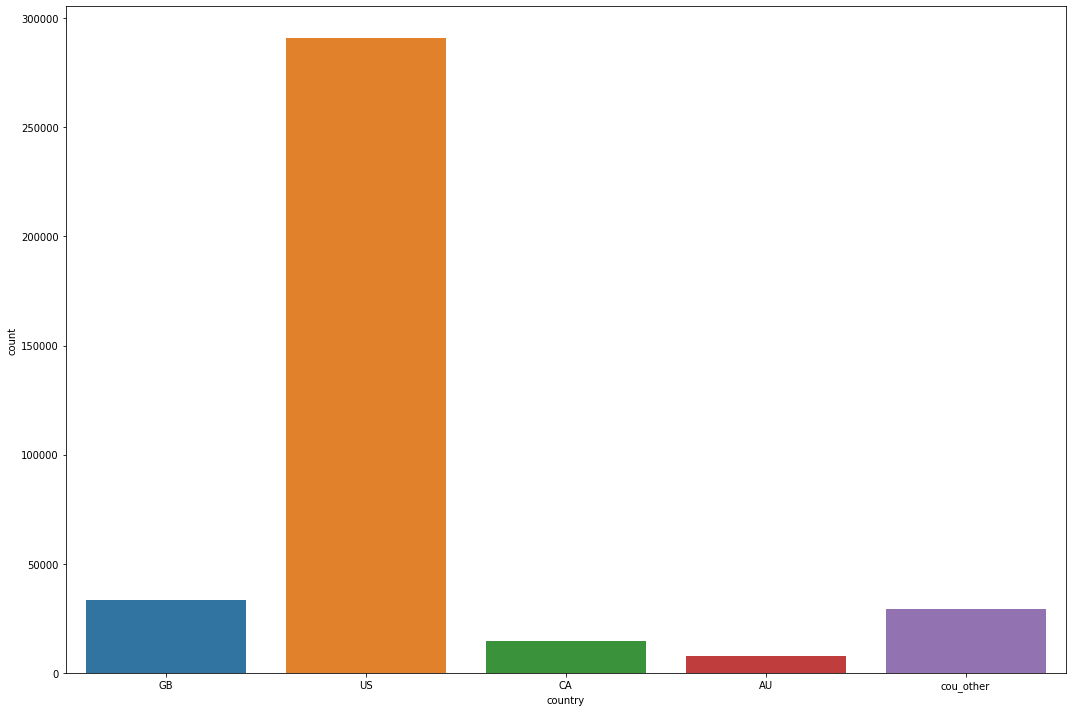

In [84]:
plt.figure(figsize=(15, 10))
sns.countplot(x='country', data=data)
plt.tight_layout()

### launched & deadline

launchedとdeadlineのデータからは
- クラウドファンディングを募集していた時期
- クラウドファンディングの募集期間

の情報が得られる．<br>
クラウドファンディングを行う季節の情報はlaunchedとdeadlineの月のデータから得られる．<br>
募集期間に関してはdeadlineとlaunchedの差の日数をとることで得られる．

In [28]:
# deadlineをstr型からdatetime型に変更
data['deadline'] = pd.to_datetime(data['deadline'])
# deadlineの一つ目のデータの月を抽出
print(data['deadline'][0].month)

10


In [29]:
# launchedについてもdatetime型に変更
data['launched'] = pd.to_datetime(data['launched'])

In [30]:
# 募集していた期間を新たな変数time_periodとしてdataに加える
data['time_period'] = data['deadline'] - data['launched']
data['time_period_days'] = data['time_period'].dt.days
data.head()

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58 days 11:47:32,58
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59 days 19:16:03,59
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44 days 23:39:10,44
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29 days 20:35:49,29
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55 days 15:24:57,55


### time_period_days

time_period_daysは何日間クラウドファンディングの募集を行っていたかを表す新しい変数である．<br>
この変数の各々の数値について出現頻度のグラフを以下に示す．

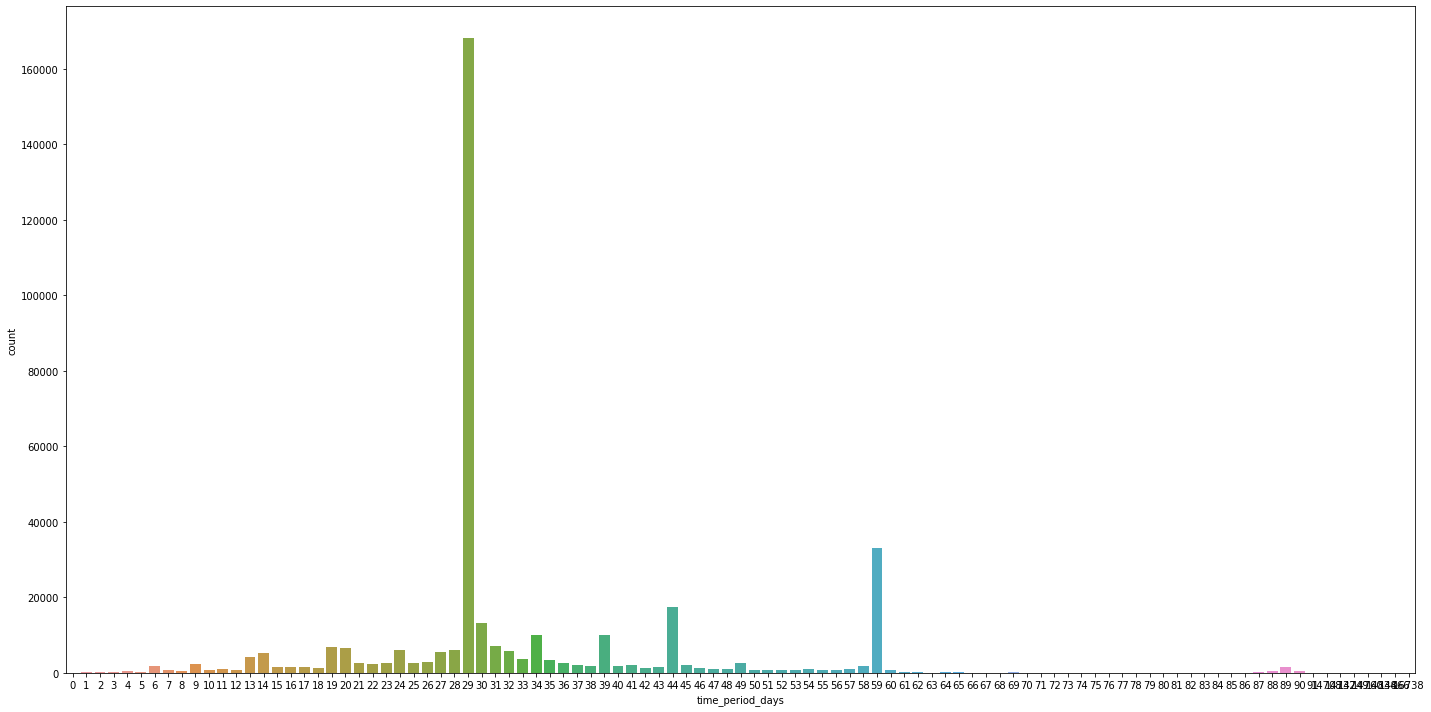

In [37]:
plt.figure(figsize=(20, 10))
sns.countplot(x='time_period_days', data=data)
plt.tight_layout()

In [47]:
data['time_period_days'].value_counts()

29       168112
59        33018
44        17552
30        13197
34        10014
          ...  
14732         1
14760         1
16738         1
14866         1
14834         1
Name: time_period_days, Length: 99, dtype: int64

In [41]:
data_29days = data['time_period_days']==29
print(f'29日間募集を行っていた件数 : {data_29days.sum() / data.shape[0]}')

29日間募集を行っていた件数 : 0.44727054078358547


In [48]:
data_time_period_days = data['time_period_days'].value_counts()
data_time_period_days = pd.DataFrame(data_time_period_days)

print('time_period_daysの出現回数が50回以下のカテゴリ数')
print(sum(data_time_period_days['time_period_days'] <= 50))
print('time_period_daysの出現回数が50回以下のデータ数')
print(data_time_period_days[data_time_period_days['time_period_days'] <= 50].sum()[0] / data.shape[0])

time_period_daysの出現回数が50回以下のカテゴリ数
10
time_period_daysの出現回数が50回以下のデータ数
0.00030330280794546935


In [49]:
data['time_period_days'].max()

16738

In [50]:
data[data['time_period_days']==16738]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
319002,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01 01:00:00,failed,CH,1905.97,16738 days 23:00:00,16738


この分布から29日間募集しているものが多く全体の44.72%を占めていることがわかる．<br>
また最大で16738日間(約45年間)行っているものもあることがわかった．<br>
しかしこのデータはlaunchedが1970年1月1日になっており，以下のkickstarterのHPに記載されているkickstarterの誕生以前から存在することになるので，外れ値である．<br>
https://www.kickstarter.com/about?ref=global-footer<br>
ここでlaunchedのデータについて2009年4月28日以前に開始されているデータは以下の12件である．

In [52]:
data[data['launched'] <= datetime.datetime(2009, 4, 28)]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
2842,Film & Video,Film & Video,USD,2010-09-15,5000.0,1970-01-01 01:00:00,failed,US,5000.00,14866 days 23:00:00,14866
48147,Art,Art,USD,2010-08-14,15000.0,1970-01-01 01:00:00,failed,US,15000.00,14834 days 23:00:00,14834
75397,Film & Video,Film & Video,USD,2010-05-21,700.0,1970-01-01 01:00:00,failed,US,700.00,14749 days 23:00:00,14749
94579,Theater,Theater,USD,2010-06-01,4000.0,1970-01-01 01:00:00,failed,US,4000.00,14760 days 23:00:00,14760
122662,Fashion,Fashion,USD,2009-05-26,1900.0,2009-04-27 14:10:39,failed,US,1900.00,28 days 09:49:21,28
138572,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,successful,US,20.00,8 days 02:07:57,8
169268,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,failed,US,1000.00,39 days 02:57:12,39
247913,Music,Music,USD,2010-05-04,10000.0,1970-01-01 01:00:00,failed,US,10000.00,14732 days 23:00:00,14732
273779,Design,Design,USD,2010-04-10,500.0,1970-01-01 01:00:00,failed,US,500.00,14708 days 23:00:00,14708
319002,Publishing,Publishing,CHF,2015-10-31,1900.0,1970-01-01 01:00:00,failed,CH,1905.97,16738 days 23:00:00,16738


この12件のうちlaunchedが1970-01-01でない5件については2009年4月28日以前から開始されているが，募集期間の長さから考えて異常と言える数値ではないのでこの値を使用する．<br>
一方，launchedが1970-01-01となった7件についてはlaunchedを2009-4-28 00:00:00に変更する．

In [55]:
data = data.replace({datetime.datetime(1970, 1, 1, 1) : datetime.datetime(2009, 4, 28)})
data

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
0,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,failed,GB,1533.95,58 days 11:47:32,58
1,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,failed,US,30000.00,59 days 19:16:03,59
2,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,failed,US,45000.00,44 days 23:39:10,44
3,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,failed,US,5000.00,29 days 20:35:49,29
4,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,failed,US,19500.00,55 days 15:24:57,55
...,...,...,...,...,...,...,...,...,...,...,...
378656,Documentary,Film & Video,USD,2014-10-17,50000.0,2014-09-17 02:35:30,failed,US,50000.00,29 days 21:24:30,29
378657,Narrative Film,Film & Video,USD,2011-07-19,1500.0,2011-06-22 03:35:14,failed,US,1500.00,26 days 20:24:46,26
378658,Narrative Film,Film & Video,USD,2010-08-16,15000.0,2010-07-01 19:40:30,failed,US,15000.00,45 days 04:19:30,45
378659,Technology,Technology,USD,2016-02-13,15000.0,2016-01-13 18:13:53,failed,US,15000.00,30 days 05:46:07,30


In [60]:
# 再度，募集していた期間を新たな変数time_periodとしてdataに加える
data['time_period'] = data['deadline'] - data['launched']
data['time_period_days'] = data['time_period'].dt.days

In [62]:
data['time_period_days'].value_counts()

29      168112
59       33018
44       17552
30       13197
34       10014
         ...  
388          1
473          1
347          1
2377         1
505          1
Name: time_period_days, Length: 99, dtype: int64

launchedの異常値はこれで取り除くことができたが，deadlineについても異常値の除去を行う必要がある．<br>
deadlineの異常値として考えられるものはlaunchedがdeadlineよりも後に来ている，つまり変数time_periodが負の値になっている状況である．<br>
まず異常値の候補である，変数time_period_daysが0以下のデータを抽出する．

In [77]:
data[data['time_period_days']<=0]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days
899,Video Games,Games,GBP,2015-06-11,5000.0,2015-06-10 19:03:39,failed,GB,7743.29,0 days 04:56:21,0
937,Classical Music,Music,USD,2016-02-19,500.0,2016-02-18 04:29:22,failed,US,500.00,0 days 19:30:38,0
10449,Software,Technology,USD,2017-03-05,10000000.0,2017-03-04 01:25:03,failed,US,10000000.00,0 days 22:34:57,0
12494,Film & Video,Film & Video,GBP,2016-06-15,130.0,2016-06-14 02:24:00,successful,GB,185.73,0 days 21:36:00,0
20368,Art,Art,USD,2016-04-02,8888.0,2016-04-01 08:38:27,failed,US,8888.00,0 days 15:21:33,0
...,...,...,...,...,...,...,...,...,...,...,...
368567,Poetry,Publishing,GBP,2014-03-02,5.0,2014-03-01 13:20:34,successful,GB,8.39,0 days 10:39:26,0
370904,Digital Art,Art,SGD,2016-08-02,5.0,2016-08-01 21:44:53,successful,SG,3.73,0 days 02:15:07,0
372363,Tabletop Games,Games,EUR,2017-08-06,69.0,2017-08-05 18:05:40,failed,FR,81.18,0 days 05:54:20,0
375553,Publishing,Publishing,USD,2016-02-28,250.0,2016-02-27 04:40:59,successful,US,250.00,0 days 19:19:01,0


募集期間が1日以下のデータは102件あることがわかる．<br>
この中でtime_periodが負の値になっているものを見つけることを考える．<br>
ここでtime_periodはdeadline - launchedを計算しているので，time_periodの絶対値とtime_periodが一致しないデータは異常であると考えられるので，全データに対してtime_periodとtime_periodの絶対値の比較を行う．<br>

In [80]:
data[data['time_period']!=abs(data['deadline'] - data['launched'])]

,category,main_category,currency,deadline,goal,launched,state,country,usd_goal_real,time_period,time_period_days


上記のようにtime_periodとtime_periodの絶対値が一致しないデータは存在しないため，deadlineについては異常値は存在しないと考えられる．

### goal

### usd_goal_real

# 目的変数と説明変数の関係性

## 目的変数の変換

## 説明変数の変換

main_categoryは15種類存在し，
- Music, Theater, Danceはfailedよりもsuccessfulの方が多い
- Food, Technologyは他のカテゴリよりも成功率が低い
- Design, Gamesは他のカテゴリよりもcanceledの割合が高い

ということがわかる．